In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

In [3]:
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix


pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

# Heart Disease - predicting heart disease or attack

In [4]:
heart_disease = pd.read_csv(r'C:\Users\Jack Dunne\Desktop\NCI_DMML\heart_disease_health_indicators.csv')

heart_disease = heart_disease.drop(columns=['PhysActivity','Fruits','NoDocbcCost','AnyHealthcare', 
                                            'Veggies', 'HvyAlcoholConsump', 'GenHlth', 'Income',
                                            'MentHlth', 'PhysHlth', 'DiffWalk', 'CholCheck', 'Education' ])

# 1 == MALE, 0 == FEMALE
heart_disease['Sex'].replace(1, 2, inplace=True)
heart_disease['Sex'].replace(0, 1, inplace=True)
heart_disease['Sex'].replace(2, 0, inplace=True)



heart_disease['Diabetes'].replace(0.0, 'No Diabetes', inplace=True)
heart_disease['Diabetes'].replace(1.0, 'T1DM', inplace=True)
heart_disease['Diabetes'].replace(2.0, 'T2DM', inplace=True)

# mapping the ages to the age variable
age_list = [22, 85]
age_list1 = [age for age in range(27, 81, 5)]
age_list.extend(age_list1)
age_list.sort()

age_brackets = []
for item in heart_disease['Age'].unique():
    age_brackets.append(item)
age_brackets.sort()

age_type_map = {age_brackets[i]:age_list[i] for i in range(len(age_brackets))}
heart_disease['Age'] = heart_disease['Age'].map(age_type_map)

In [5]:
heart_disease.columns

Index(['HeartDiseaseorAttack', 'HighBP', 'HighChol', 'BMI', 'Smoker', 'Stroke',
       'Diabetes', 'Sex', 'Age'],
      dtype='object')

## Heart Disease EDA

Sex                    -0.086096
BMI                     0.052904
Smoker                  0.114441
HighChol                0.180765
Stroke                  0.203002
HighBP                  0.209361
Age                     0.223210
HeartDiseaseorAttack    1.000000
Name: HeartDiseaseorAttack, dtype: float64

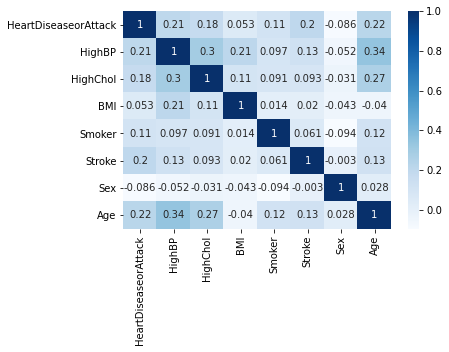

In [6]:
corr_matrix = heart_disease.corr()
sb.heatmap(corr_matrix, cmap="Blues", annot=True)
corr_matrix["HeartDiseaseorAttack"].sort_values(ascending=True)

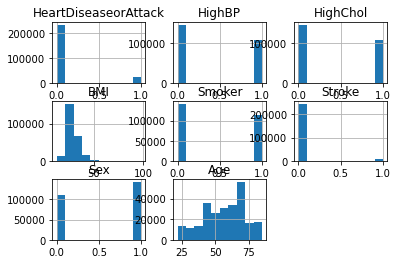

In [7]:
from matplotlib import pyplot

heart_disease.hist()
pyplot.show()

## Training/Testing Models

In [8]:
subset = ['HighBP', 'HighChol', 'BMI', 'Smoker', 'Stroke','Diabetes', 'Sex', 'Age']

X = heart_disease[subset]
y = heart_disease['HeartDiseaseorAttack']

In [9]:
SVC_data = heart_disease.sample(n=15000)
SVC_X = SVC_data[subset]
SVC_y = SVC_data['HeartDiseaseorAttack']

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    train_size = .80)

In [11]:
scaler = StandardScaler()
ohe = OneHotEncoder()

label_features = ['Diabetes']
scale_features = ['BMI', 'Age']

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

KNN = KNeighborsClassifier(n_neighbors=5)

logreg = LogisticRegression(solver='lbfgs', class_weight='balanced')

SVC = SVC()

NaiveBayes = GaussianNB()

In [13]:
model = logreg

In [14]:
ct = make_column_transformer((ohe, label_features), 
                             (scaler, scale_features),
                             remainder='passthrough')

pipe = make_pipeline(ct, model)

fitted_model  = pipe.fit(X_train, y_train)

### model metrics

In [15]:
cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean()

0.725254254100389

In [16]:
pd.DataFrame([
    [fitted_model.score(X_train, y_train), recall_score(y_train, fitted_model.predict(X_train))],
    [fitted_model.score(X_test, y_test), recall_score(y_test, fitted_model.predict(X_test))],
], columns = ['Accuracy', 'Recall'], index=['Train', 'Test'])

,Accuracy,Recall
Train,0.725846,0.771162
Test,0.725954,0.765014


In [17]:
y_test_pred = fitted_model.predict_proba(X_test)

print('Brier score is : ' + str(brier_score_loss(y_test, y_test_pred[:,1])))

Brier score is : 0.17898121831683256


In [18]:
y_pred = fitted_model.predict(X_test)
final = classification_report(y_test, y_pred)
print(final)

              precision    recall  f1-score   support

         0.0       0.97      0.72      0.83     45957
         1.0       0.22      0.77      0.34      4779

    accuracy                           0.73     50736
   macro avg       0.59      0.74      0.59     50736
weighted avg       0.90      0.73      0.78     50736



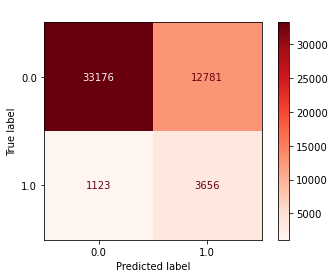

In [19]:
matrix = plot_confusion_matrix(pipe, X_test, y_test, cmap=plt.cm.Reds)
matrix.ax_.set_title('Confusion Matrix', color='white')
plt.show()

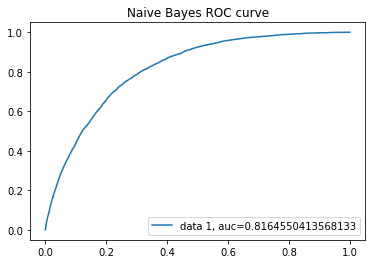

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = pipe.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('Naive Bayes ROC curve')
plt.show()

#  NY Discharges -- “length of stay” variable of interest

In [21]:
NY_discharges = pd.read_csv(r'C:\Users\Jack Dunne\Desktop\NCI_DMML\NY_Hospital_Inpatient_Discharges.csv')
NY_discharges.columns

C:\Users\Jack Dunne\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['Hospital Service Area', 'Hospital County',
       'Operating Certificate Number', 'Permanent Facility Id',
       'Facility Name', 'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race',
       'Ethnicity', 'Length of Stay', 'Type of Admission',
       'Patient Disposition', 'Discharge Year', 'CCS Diagnosis Code',
       'CCS Diagnosis Description', 'CCS Procedure Code',
       'CCS Procedure Description', 'APR DRG Code', 'APR DRG Description',
       'APR MDC Code', 'APR MDC Description', 'APR Severity of Illness Code',
       'APR Severity of Illness Description', 'APR Risk of Mortality',
       'APR Medical Surgical Description', 'Payment Typology 1',
       'Payment Typology 2', 'Payment Typology 3', 'Birth Weight',
       'Abortion Edit Indicator', 'Emergency Department Indicator',
       'Total Charges', 'Total Costs'],
      dtype='object')

In [22]:
NY_discharges = pd.read_csv(r'C:\Users\Jack Dunne\Desktop\NCI_DMML\NY_Hospital_Inpatient_Discharges.csv')

columns = ['Age Group', 'Gender', 'Type of Admission','Patient Disposition', 'APR MDC Description', 
          'APR Severity of Illness Description', 'Emergency Department Indicator', 'Length of Stay']

NY_discharges = NY_discharges[columns]



#Simplifying the dataset to only those who are independent at home and those who are not
patient_disp = ['Court/Law Enforcement', 'Short-term Hospital',
             'Expired',
             'Another Type Not Listed',
             'Left Against Medical Advice',
             "Cancer Center or Children's Hospital",
             'Hospice - Home',
             'Psychiatric Hospital or Unit of Hosp',
             'Facility w/ Custodial/Supportive Care',
             'Hosp Basd Medicare Approved Swing Bed',
             'Federal Health Care Facility',
             'Critical Access Hospital',
             'Admitted from Ambulatory Surgery']

NY_discharges = NY_discharges.drop(NY_discharges[NY_discharges['Patient Disposition'].isin(patient_disp)].index)

NY_discharges = NY_discharges.drop(NY_discharges[NY_discharges['Age Group'].isin(['0 to 17'])].index)

NY_discharges = NY_discharges.drop(NY_discharges[NY_discharges['Gender'].isin(['U'])].index)



# removing columns to focus on general internal medicine
diseases_list = ['Mental Diseases and Disorders',
                 'Infectious and Parasitic Diseases, Systemic or Unspecified Sites',
                 'Ear, Nose, Mouth, Throat and Craniofacial Diseases and Disorders',
                 'Pregnancy, Childbirth and the Puerperium',
                 'Lymphatic, Hematopoietic, Other Malignancies, Chemotherapy and Radiotherapy',
                 'Alcohol/Drug Use and Alcohol/Drug Induced Organic Mental Disorders',
                 'Rehabilitation, Aftercare, Other Factors Influencing Health Status and Other Health Service Contacts',
                 'Poisonings, Toxic Effects, Other Injuries and Other Complications of Treatment',
                 'Burns',
                 'Diseases and Disorders of Blood, Blood Forming Organs and Immunological Disorders',
                 'Diseases and Disorders of the Eye',
                 'Human Immunodeficiency Virus Infections',
                 'Diseases and Disorders of the Female Reproductive System',
                 'Multiple Significant Trauma',
                 'Newborns and Other Neonates with Conditions Originating in the Perinatal Period']

NY_discharges = NY_discharges.drop(NY_discharges[NY_discharges['APR MDC Description'].isin(diseases_list)].index)
NY_discharges.drop(columns=['APR MDC Description'], inplace=True)



admission_list = ['Trauma', 'Not Available', 'Newborn']
NY_discharges = NY_discharges.drop(NY_discharges[NY_discharges['Type of Admission'].isin(admission_list)].index)

los_list = ['1','2','3', '4', '5', '120 +']
NY_discharges = NY_discharges.drop(NY_discharges[NY_discharges['Length of Stay'].isin(los_list)].index)


severity_list = ['Extreme']
NY_discharges = NY_discharges.drop(NY_discharges[NY_discharges['APR Severity of Illness Description'].isin(severity_list)].index)

NY_discharges['Patient Disposition'] = np.where(NY_discharges['Patient Disposition'] == 'Home or Self Care' , 0, 1 )
NY_discharges.rename(columns={"Patient Disposition": "Not Independent in Care"}, inplace=True)

NY_discharges['Length of Stay'] = pd.to_numeric(NY_discharges['Length of Stay']) 
pd.set_option('display.float_format', '{:.5f}'.format)

## EDA

<AxesSubplot:>

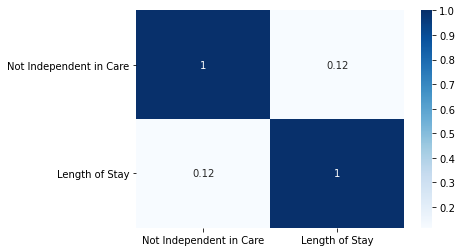

In [23]:
corr_matrix = NY_discharges.corr()
sb.heatmap(corr_matrix, cmap="Blues", annot=True)

In [24]:
corr_matrix

,Not Independent in Care,Length of Stay
Not Independent in Care,1.00000,0.11529
Length of Stay,0.11529,1.00000


## Model Building

In [25]:
X = NY_discharges.loc[:, NY_discharges.columns != 'Length of Stay']
y = NY_discharges['Length of Stay']

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size = .80)

In [27]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

ohe = OneHotEncoder()
scaler = StandardScaler()

age_lvl = [ '18 to 29', '30 to 49', '50 to 69', '70 or Older']
admission_lvl = [ 'Elective', 'Urgent', 'Emergency' ]
severity_lvl = [ 'Minor', 'Moderate', 'Major' ]


ordinal_features = ['Age Group', 'Type of Admission', 'APR Severity of Illness Description']
ohe_features = ['Gender', 'Emergency Department Indicator']
scale_features = ['Length of Stay']
binary = ['Not Independent in Care']


ct = make_column_transformer((OrdinalEncoder(categories=[age_lvl]), ['Age Group']),
                             (OrdinalEncoder(categories=[admission_lvl]), ['Type of Admission']),
                             (OrdinalEncoder(categories=[severity_lvl]), ['APR Severity of Illness Description']),
                             (ohe, ohe_features), 
                             remainder = 'passthrough')

### model selection

In [28]:
# regression models

import sklearn.linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV

rfr = RandomForestRegressor(n_estimators=100)
lin_reg = sklearn.linear_model.LinearRegression()
lasso = LassoCV(cv=3)

In [29]:
model = lasso

In [30]:
pipe = make_pipeline(ct, model)

fitted_model  = pipe.fit(X_train, y_train)

### model metrics

In [31]:
cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()

-45.066402447839685

In [32]:
# R^2 value

pipe.score(X_test, y_test)

0.0416434056562166

In [33]:
# MAE
# average of absolute differences between predictions and actual values

from sklearn.metrics import mean_absolute_error

y_pred = pipe.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mae

3.965621723535556

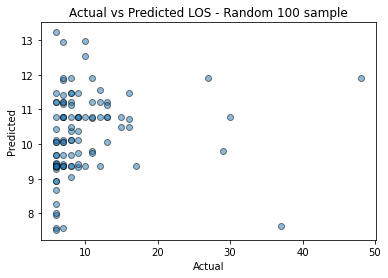

In [34]:
df = pd.DataFrame(data={'actual values': y_test, 'predicted values':y_pred})

graph_data = df.sample(n=100)

plt.scatter(graph_data['actual values'], graph_data['predicted values'], cmap='summer', edgecolor='black', alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted LOS - Random 100 sample')

plt.show()

### Using a classifier instead of a regression model

In [35]:
bins = [0, 7, 14, 28, np.inf]
names = ['5-7', '8-14', '15-28', '1month+']

NY_discharges['LOS_cats'] = pd.cut(NY_discharges['Length of Stay'], bins, labels=names)

print(NY_discharges.dtypes)

Age Group                                object
Gender                                   object
Type of Admission                        object
Not Independent in Care                   int32
APR Severity of Illness Description      object
Emergency Department Indicator           object
Length of Stay                            int64
LOS_cats                               category
dtype: object


#### SVC sample group

In [36]:
SVC_data = NY_discharges.sample(n=20000)
SVC_X = SVC_data.drop(['Length of Stay', 'LOS_cats'], axis=1)
SVC_y = SVC_data['LOS_cats']

In [37]:
X = NY_discharges.drop(['Length of Stay', 'LOS_cats'], axis=1)
y = NY_discharges['LOS_cats']

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y, 
                                                    train_size = .80)

In [39]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

ohe = OneHotEncoder()
scaler = StandardScaler()

age_lvl = [ '18 to 29', '30 to 49', '50 to 69', '70 or Older']
admission_lvl = [ 'Elective', 'Urgent', 'Emergency' ]
severity_lvl = [ 'Minor', 'Moderate', 'Major' ]
los_lvl = ['5-7', '8-14', '15-28', '1month+']


ordinal_features = ['Age Group', 'Type of Admission', 'APR Severity of Illness Description', 'LOS_cats']
ohe_features = ['Gender', 'Emergency Department Indicator']
# scale_features = ['Length of Stay']
binary = ['Not Independent in Care']


ct = make_column_transformer((OrdinalEncoder(categories=[age_lvl]), ['Age Group']),
                             (OrdinalEncoder(categories=[admission_lvl]), ['Type of Admission']),
                             (OrdinalEncoder(categories=[severity_lvl]), ['APR Severity of Illness Description']),
#                              (OrdinalEncoder(categories=[los_lvl]), ['LOS_cats']),
                             (ohe, ohe_features), 
#                              (scaler, scale_features),
                             remainder = 'passthrough')

### model selection

In [40]:
# classification models 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression


KNN = KNeighborsClassifier(n_neighbors=5)

logreg = LogisticRegression(solver='lbfgs', class_weight='balanced')

SVC = SVC()

In [41]:
model = logreg

In [42]:
pipe = make_pipeline(ct, model)

fitted_model  = pipe.fit(X_train, y_train)

### model metrics

In [43]:
cross_val_score(pipe, X_train, y_train, cv=3, scoring='accuracy').mean()

0.30066658005255875

In [44]:
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import classification_report


pd.DataFrame([
    [fitted_model.score(X_train, y_train), 
     recall_score(y_train, fitted_model.predict(X_train), average='weighted')],
    [fitted_model.score(X_test, y_test), 
     recall_score(y_test, fitted_model.predict(X_test), average='weighted')],
], columns = ['Accuracy', 'Recall'], index=['Train', 'Test'])

,Accuracy,Recall
Train,0.30123,0.30123
Test,0.30245,0.30245


In [45]:
y_pred = fitted_model.predict(X_test)
final = classification_report(y_test, y_pred)
print(final)

              precision    recall  f1-score   support

       15-28       0.15      0.31      0.20      6641
     1month+       0.05      0.50      0.08      1264
         5-7       0.52      0.53      0.53     23279
        8-14       0.46      0.07      0.12     24173

    accuracy                           0.30     55357
   macro avg       0.29      0.35      0.23     55357
weighted avg       0.44      0.30      0.30     55357



In [46]:
confusion_matrix(y_test, y_pred)

array([[ 2091,  2529,  1625,   396],
       [  333,   633,   236,    62],
       [ 5000,  4405, 12400,  1474],
       [ 6585,  6333,  9636,  1619]], dtype=int64)

# Diabetes Dataset

In [47]:
diabetes_df = pd.read_csv(r'C:\Users\Jack Dunne\Desktop\NCI_DMML\diabetic_data.csv')

filt = diabetes_df['admission_type_id'] > 3
diabetes_df = diabetes_df.drop(index=diabetes_df[filt].index)

admission_type_map = {1:'Emergency', 2:'Urgent', 3:'Elective'}
diabetes_df['admission_type_id'] = diabetes_df['admission_type_id'].map(admission_type_map)

# viewing only caucasian patients to target one patient cohort
filt = diabetes_df['race'] == 'Caucasian'
diabetes_df = diabetes_df[filt]

#df['my_channel'] = np.where(df.my_channel > 20000, 0, df.my_channel)
diabetes_df['readmitted'] = diabetes_df['readmitted'].astype(str)
diabetes_df['readmitted'] = np.where(diabetes_df['readmitted'] == '<30' , 1, 0 )


diabetes_df['insulin'] = np.where(diabetes_df['insulin'] == 'No' , 0, 1 )

# 1 == MALE, 0 == FEMALE
diabetes_df['gender'] = np.where(diabetes_df['gender'] == 'Male' , 1, 0 )


age_brackets = []
for item in diabetes_df['age'].unique():
    age_brackets.append(item)
age_brackets.sort()
averaged_ages = [x for x in range(5,100, 10)]
age_type_map = {age_brackets[i]:averaged_ages[i] for i in range(len(averaged_ages))}
diabetes_df['age'] = diabetes_df['age'].map(age_type_map)


# dropping the columns
diabetes_df = diabetes_df.drop(columns=['race', 'encounter_id', 'patient_nbr', 'discharge_disposition_id', 'admission_source_id', 
                                        'payer_code', 'medical_specialty','num_lab_procedures', 
                                       'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult',
                                       'repaglinide', 'nateglinide', 'chlorpropamide',
                                       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
                                       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
                                       'tolazamide', 'examide', 'citoglipton',
                                       'glyburide-metformin', 'glipizide-metformin', 'metformin', 'diabetesMed',  
                                       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                                        'number_outpatient', 'number_emergency',
                                       'metformin-pioglitazone', 'change', 'weight' ])


In [48]:
diabetes_df.info()

#Assessing for any na values
diabetes_df.isna().sum()

diabetes_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67538 entries, 1 to 101765
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gender             67538 non-null  int32 
 1   age                67538 non-null  int64 
 2   admission_type_id  67538 non-null  object
 3   time_in_hospital   67538 non-null  int64 
 4   num_procedures     67538 non-null  int64 
 5   num_medications    67538 non-null  int64 
 6   number_inpatient   67538 non-null  int64 
 7   number_diagnoses   67538 non-null  int64 
 8   insulin            67538 non-null  int32 
 9   readmitted         67538 non-null  int32 
dtypes: int32(3), int64(6), object(1)
memory usage: 4.9+ MB


,gender,age,time_in_hospital,num_procedures,num_medications,number_inpatient,number_diagnoses,insulin,readmitted
count,67538.00000,67538.00000,67538.00000,67538.00000,67538.00000,67538.00000,67538.00000,67538.00000,67538.00000
mean,0.47905,67.50170,4.40213,1.37672,16.25737,0.64179,7.59790,0.51935,0.11361
std,0.49956,15.50676,2.98013,1.75088,8.22623,1.26576,1.87068,0.49963,0.31734
min,0.00000,5.00000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000
25%,0.00000,55.00000,2.00000,0.00000,11.00000,0.00000,6.00000,0.00000,0.00000
50%,0.00000,65.00000,4.00000,1.00000,15.00000,0.00000,9.00000,1.00000,0.00000
75%,1.00000,75.00000,6.00000,2.00000,20.00000,1.00000,9.00000,1.00000,0.00000
max,1.00000,95.00000,14.00000,6.00000,81.00000,21.00000,16.00000,1.00000,1.00000


## EDA

num_procedures     -0.01758
gender             -0.00689
age                 0.01897
num_medications     0.03659
insulin             0.03969
time_in_hospital    0.03987
number_diagnoses    0.05256
number_inpatient    0.16089
readmitted          1.00000
Name: readmitted, dtype: float64

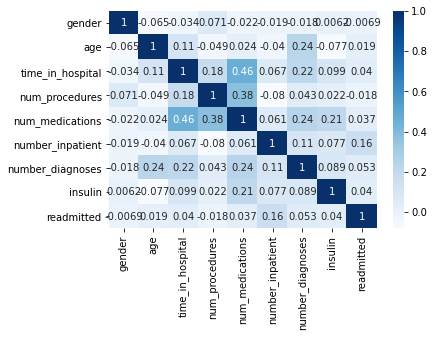

In [49]:
corr_matrix = diabetes_df.corr()
sb.heatmap(corr_matrix, cmap="Blues", annot=True)
corr_matrix["readmitted"].sort_values(ascending=True)

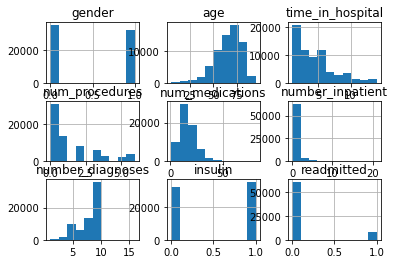

In [50]:
from matplotlib import pyplot

diabetes_df.hist()
pyplot.show()

## Training/Testing Models

In [51]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

In [52]:
all_cols = ['gender', 'age', 'admission_type_id', 'time_in_hospital',
       'num_procedures', 'num_medications', 'number_inpatient',
       'number_diagnoses', 'insulin']

subset = ['gender', 'age',  'time_in_hospital', 'insulin', 'admission_type_id']

X = diabetes_df[subset]
y = diabetes_df['readmitted']

In [53]:
SVC_data = diabetes_df.sample(n=20000)
SVC_X = SVC_data[subset]
SVC_y = SVC_data['readmitted']

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    train_size = .80)

In [55]:
ohe = OneHotEncoder()
scaler = StandardScaler()

In [56]:
feature_skew = X.select_dtypes(include=[np.number]).skew()

In [57]:
scale_features = ['age', 'time_in_hospital']
boolean_features = ['gender', 'insulin']
label_features = ['admission_type_id']

#(FunctionTransformer(np.log1p, validate=False), log_features),

### model selection

In [58]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

KNN = KNeighborsClassifier(n_neighbors=5)

logreg = LogisticRegression(solver='lbfgs', class_weight='balanced')

SVC = SVC()

GNB = GaussianNB()

In [59]:
model = logreg

In [60]:
ct = make_column_transformer((ohe, label_features), 
                             (scaler, scale_features),
                             remainder='passthrough')

pipe = make_pipeline(ct, model)

fitted_model  = pipe.fit(X_train, y_train)

### model metrics

In [61]:
cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean()

0.5303535073107533

In [62]:
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import classification_report


pd.DataFrame([
    [fitted_model.score(X_train, y_train), recall_score(y_train, fitted_model.predict(X_train))],
    [fitted_model.score(X_test, y_test), recall_score(y_test, fitted_model.predict(X_test))],
], columns = ['Accuracy', 'Recall'], index=['Train', 'Test'])

,Accuracy,Recall
Train,0.53455,0.54106
Test,0.53213,0.53160


In [63]:
y_test_pred = fitted_model.predict_proba(X_test)

print('Brier score is : ' + str(brier_score_loss(y_test, y_test_pred[:,1])))

Brier score is : 0.24799217517502575


In [64]:
y_pred = fitted_model.predict(X_test)
final = classification_report(y_test, y_pred)
print(final)

              precision    recall  f1-score   support

           0       0.90      0.53      0.67     11973
           1       0.13      0.53      0.21      1535

    accuracy                           0.53     13508
   macro avg       0.51      0.53      0.44     13508
weighted avg       0.81      0.53      0.62     13508



In [65]:
confusion_matrix(y_test, y_pred)

array([[6372, 5601],
       [ 719,  816]], dtype=int64)

Text(0.5, 1.0, 'Logistic Regression Confusion Matrix- Readmission')

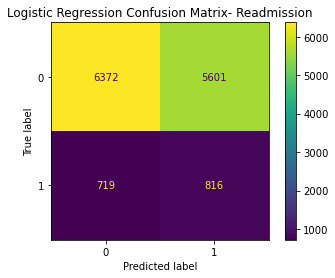

In [66]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipe, X_test, y_test)
plt.title('Logistic Regression Confusion Matrix- Readmission')


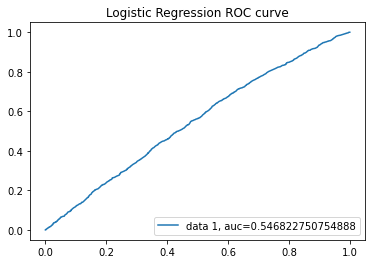

In [67]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = pipe.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('Logistic Regression ROC curve')
plt.show()